### Example 7.2: Navier-Stokes Channel Flow

Having looked at the case for cavity flow, let's now look at another case: channel flow. The code for this resembles our earlier code quite a lot, with some differences. We begin with definitions, very similar to the ones in cavity flow.

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

##variable declarations
nx = 41
ny = 41
nt = 10
nit = 50 
c = 1
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

##physical variables
rho = 1
nu = .1
F = 1
dt = .01

#initial conditions
u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
b = np.zeros((nx, ny))

p = np.ones((nx, ny))

un = np.zeros((nx, ny))
vn = np.zeros((nx, ny))

pn = np.ones((nx, ny))

Now let's define our functions. You'll note the similarities between these and functions we used for cavity flow earlier. These are quite a mess for now. The devito implementation will prove to be much lighter with syntax, and end up being far fewer lines of code, but we'll bear with this for now so we can compare our outputs.

In [2]:
def build_up_b(rho, dt, dx, dy, u, v):
    b = np.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                                      (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                            ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                            2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                                 (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                            ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    # Periodic BC Pressure @ x = 2
    b[1:-1, -1] = (rho * (1 / dt * ((u[1:-1, 0] - u[1:-1,-2]) / (2 * dx) +
                                    (v[2:, -1] - v[0:-2, -1]) / (2 * dy)) -
                          ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx))**2 -
                          2 * ((u[2:, -1] - u[0:-2, -1]) / (2 * dy) *
                               (v[1:-1, 0] - v[1:-1, -2]) / (2 * dx)) -
                          ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))**2))

    # Periodic BC Pressure @ x = 0
    b[1:-1, 0] = (rho * (1 / dt * ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx) +
                                   (v[2:, 0] - v[0:-2, 0]) / (2 * dy)) -
                         ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))**2 -
                         2 * ((u[2:, 0] - u[0:-2, 0]) / (2 * dy) *
                              (v[1:-1, 1] - v[1:-1, -1]) / (2 * dx))-
                         ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))**2))
    
    return b

In [3]:
def pressure_poisson_periodic(p, dx, dy):
    pn = np.empty_like(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])

        # Periodic BC Pressure @ x = 2
        p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, -1])

        # Periodic BC Pressure @ x = 0
        p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 0])
        
        # Wall boundary conditions, pressure
        p[-1, :] =p[-2, :]  # dp/dy = 0 at y = 2
        p[0, :] = p[1, :]  # dp/dy = 0 at y = 0
    
    return p

In [4]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
        u[-1, :] = 1    #set velocity on cavity lid equal to 1

        v[0, :] = 0
        v[-1, :]=0
        v[:, 0] = 0
        v[:, -1] = 0
        
        
    return u, v, p

Like in our last example, let's compare what happens when nt = 100 versus when nt takes a higher value, nt = 700.

In [5]:
udiff = 1
stepcount = 0

while udiff > .001:
    un = u.copy()
    vn = v.copy()

    b = build_up_b(rho, dt, dx, dy, u, v)
    p = pressure_poisson_periodic(p, dx, dy)

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * (dt / dx**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                     F * dt)

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * rho * dy) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    # Periodic BC u @ x = 2     
    u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                  (un[1:-1, -1] - un[1:-1, -2]) -
                   vn[1:-1, -1] * dt / dy * 
                  (un[1:-1, -1] - un[0:-2, -1]) -
                   dt / (2 * rho * dx) *
                  (p[1:-1, 0] - p[1:-1, -2]) + 
                   nu * (dt / dx**2 * 
                  (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                   dt / dy**2 * 
                  (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

    # Periodic BC u @ x = 0
    u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (un[1:-1, 0] - un[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy * 
                 (un[1:-1, 0] - un[0:-2, 0]) - 
                  dt / (2 * rho * dx) * 
                 (p[1:-1, 1] - p[1:-1, -1]) + 
                  nu * (dt / dx**2 * 
                 (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                  dt / dy**2 *
                 (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

    # Periodic BC v @ x = 2
    v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                  (vn[1:-1, -1] - vn[1:-1, -2]) - 
                   vn[1:-1, -1] * dt / dy *
                  (vn[1:-1, -1] - vn[0:-2, -1]) -
                   dt / (2 * rho * dy) * 
                  (p[2:, -1] - p[0:-2, -1]) +
                   nu * (dt / dx**2 *
                  (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                   dt / dy**2 *
                  (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

    # Periodic BC v @ x = 0
    v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (vn[1:-1, 0] - vn[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy *
                 (vn[1:-1, 0] - vn[0:-2, 0]) -
                  dt / (2 * rho * dy) * 
                 (p[2:, 0] - p[0:-2, 0]) +
                  nu * (dt / dx**2 * 
                 (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                  dt / dy**2 * 
                 (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))


    # Wall BC: u,v = 0 @ y = 0,2
    u[0, :] = 0
    u[-1, :] = 0
    v[0, :] = 0
    v[-1, :]= 0
    
    udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
    stepcount += 1

Let's print one time to show the channel flow at different points on our diagram. First time round let's do this with more sparse arrows, then we'll show a much denser diagram.

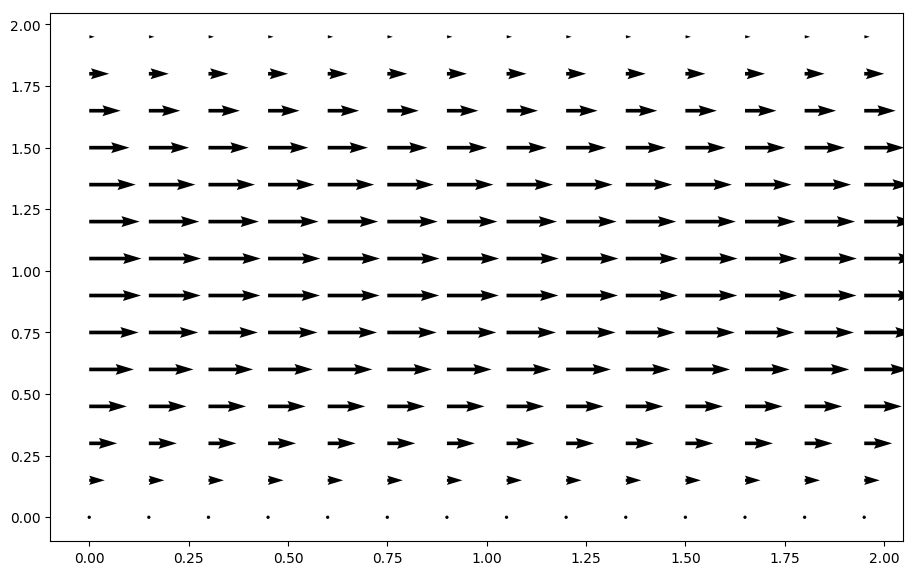

In [6]:
fig = pyplot.figure(figsize = (11,7), dpi=100)
pyplot.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3]);

Let's just print again to show all the arrows that we missed out in the above diagram.

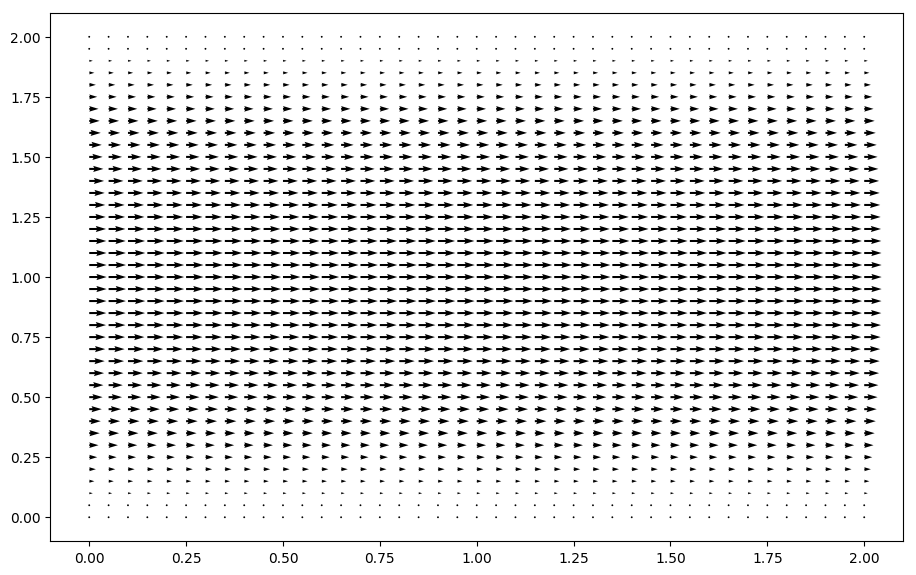

In [7]:
fig = pyplot.figure(figsize = (11,7), dpi=100)
pyplot.quiver(X, Y, u, v);

<b>Devito Implementation</b>

Now for us to try this out using Devito. Most of our code will be the same as in the <a href="https://github.com/opesci/devito/blob/cfd-examples/examples/cfd/test_07_navier_stokes_cavity_flow.ipynb">Navier-Stokes Cavity Flow exercise</a>, but we will need to update our equations.

In the channel flow case, we need to work with the equations below.

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu\Big(\frac{\partial^2u}{\partial x^2}+\frac{\partial^2u}{\partial y^2}\Big) + F$$

$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y} + \nu\Big(\frac{\partial^2v}{\partial x^2}+\frac{\partial^2v}{\partial y^2}\Big)$$

$$\frac{\partial^2p}{\partial x^2}+\frac{\partial^2p}{\partial y^2} = -\rho\Big(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x} + 2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x} + \frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\Big)$$

These differ from the earlier ones because we need to add a source term, F, to the momentum equation of u to mimic the effect of pressure-driven flow along a channel.

In [9]:
from devito import Operator, TimeData, left, x, y, t
from sympy import Eq, solve
from sympy.abc import h, s

# First create the space we need for this model
u = TimeData(name='u', shape=(nx, ny), space_order=2)
v = TimeData(name='u', shape=(nx, ny), space_order=2)
p = TimeData(name='p', shape=(nx, ny), space_order=2)
b = TimeData(name='b', shape=(nx, ny), space_order=2)

# Set up the equation as above
# For u and v's momentum equations
u_eq = Eq(u.dt + u*u.dx + v*u.dy, -1/rho*p.dx + nu*u.laplace)
v_eq = Eq(v.dt + u*v.dx + v*v.dy, -1/rho*p.dy + nu*v.laplace)
# For p's pressure equation
p_eq = Eq(p.laplace, -rho*((u.dx)**2 + 2*(u.dy)*(v.dx) + (v.dy)**2))
                 
# Set up our stencils
stencil_u = solve(u_eq, u.forward)[0]
stencil_v = solve(v_eq, v.forward)[0]
stencil_p = solve(p_eq, p.forward)
update_u = Eq(u.forward, stencil_u)
update_v = Eq(v.forward, stencil_v)
update_p = Eq(p.forward, stencil_p)

# Set Dirichlet boundary conditions using the low-level API, all equal to 1
bc_u = [Eq(u.indexed[t+1, 0, y], 1.)]  # left
bc_u += [Eq(u.indexed[t+1, nx-1, y], 1.)]  # right
bc_u += [Eq(u.indexed[t+1, x, ny-1], 1.)]  # top
bc_u += [Eq(u.indexed[t+1, x, 0], 1.)]  # bottom
bc_v = [Eq(v.indexed[t+1, 0, y], 1.)]  # left
bc_v += [Eq(v.indexed[t+1, nx-1, y], 1.)]  # right
bc_v += [Eq(v.indexed[t+1, x, ny-1], 1.)]  # top
bc_v += [Eq(v.indexed[t+1, x, 0], 1.)]  # bottom

# Create the Operator
op = Operator([update_u, update_v, update_p], + bc_u + bc_v,subs={h:dx, s:dt})

# Execute for a number of timesteps using nt from earlier
op(time=nt+1)

SympifyError: SympifyError: []

Now let's take a look at what this gives us graphically.

In [ ]:
plot_contour(X, Y, p)

That's excellent, just like we printed above. Now that we've coded something to do this in Devito we're done with our tutorial on Navier-Stokes, and also adapted and worked through all of Lorena Barba's tutorials.